In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import urllib as url
import os.path as op

top_url = 'https://stacks.stanford.edu/file/druid:ng782rw8378/'

# Download test-retest data in 3 b-values:
for s in [1, 2]:
    for b in [1000, 2000, 4000]:
        for ext in ['.nii.gz', '.bvecs', '.bvals']:
            fname = 'SUB1_b%s_%s%s'%(b,s, ext)
            if not op.exists('./data/' + fname):
                url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)
    
# Download a white matter segmentation:
fname = "SUB1_aparc-reduced.nii.gz"
if not op.exists('./data/' + fname):
    url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)

In [3]:
seg_img = nib.load('data/SUB1_aparc-reduced.nii.gz')

In [4]:
seg = seg_img.get_data()

In [5]:
# Detect the white matter portions as a mask: 
mask = (seg == 1) | (seg == 2)

In [6]:
import nibabel as nib
import dipy.core.gradients as dpg

In [7]:
def load_data(b):
    gtab1 = dpg.gradient_table('data/SUB1_b%s_1.bvals'%b, 
                              'data/SUB1_b%s_1.bvecs'%b)

    gtab2 = dpg.gradient_table('data/SUB1_b%s_2.bvals'%b, 
                              'data/SUB1_b%s_2.bvecs'%b)

    img1 = nib.load('data/SUB1_b%s_1.nii.gz'%b)
    img2 = nib.load('data/SUB1_b%s_2.nii.gz'%b)

    data1 = img1.get_data()
    data2 = img2.get_data()
    
    return gtab1, gtab2, data1, data2

In [8]:
def calc_diff(data1, data2, gtab1, gtab2, mask):
    """ Calculate test-retest difference for every measurement """
    data1_b = data1[mask][..., ~gtab1.b0s_mask].ravel()
    data2_b = data2[mask][..., ~gtab2.b0s_mask].ravel()
    diff = data1_b - data2_b
    return diff

In [9]:
from scipy import stats

KurtosistestResult(statistic=225.34009230316434, pvalue=0.0)
0.4532657453860316
KurtosistestResult(statistic=118.42930619034955, pvalue=0.0)
0.21613691663428414
KurtosistestResult(statistic=188.06809871803327, pvalue=0.0)
0.36542570483977244


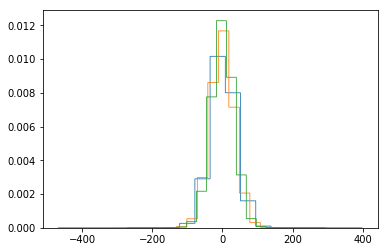

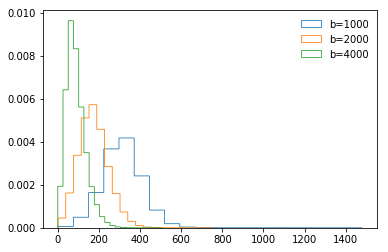

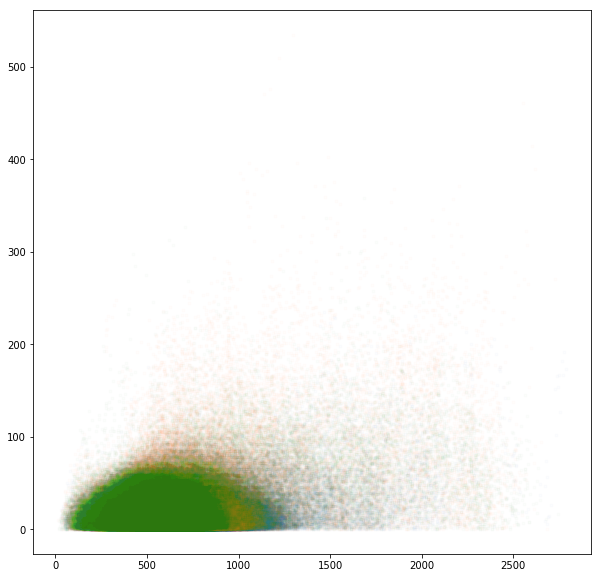

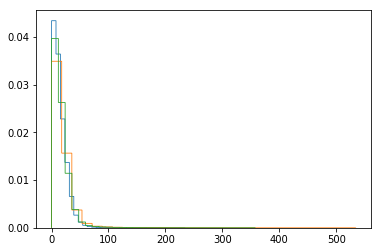

In [10]:
fig_diff, ax_diff = plt.subplots(1)
fig_hist, ax_hist = plt.subplots(1)
fig_scatter, ax_scatter = plt.subplots(1)
fig_std, ax_std = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    # Histogram of the diffusion-weighted signals:
    ax_hist.hist(data1[..., ~gtab1.b0s_mask][mask].ravel(), 
                 histtype='step', bins=20, normed=True, label='b=%s'%b)

    # Calculate the measurement-by-measurement test-retest 
    # reliability:
    diff = calc_diff(data1, data2, gtab1, gtab2, mask)
    # Is it Normal?
    print(stats.kurtosistest(diff))
    print(stats.kurtosis(diff))
    # Histogram of the differences:
    ax_diff.hist(diff, histtype='step', bins=20, 
                 normed=True, label='b=%s'%b)

    # Calculate the standard deviation for every 
    # diffusion-weighted measurement(each direction separately in each voxel):
    stack_data = np.vstack([data1[..., gtab1.b0s_mask][mask].ravel(), 
                            data2[..., gtab2.b0s_mask][mask].ravel()])

    std_data = np.std(stack_data, 0)
    mean_data = np.mean(stack_data, 0)
    # Is there a systematic relationship between standard deviation 
    # and mean signal?
    ax_scatter.plot(mean_data, std_data, '.', alpha=0.01)
    
    # What is the distribution of STD in each b-value? 
    ax_std.hist(std_data, bins=30, histtype='step', normed=True, label='b=%s'%b)

ax_hist.legend()
fig_scatter.set_size_inches([10, 10])

In [11]:
rmse = np.sqrt(np.mean(np.power(data1 - data2, 2), -1))

/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/image.py:373: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/image.py:374: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


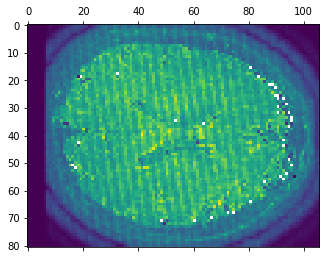

In [12]:
plt.matshow(rmse[:, :, 40], cmap='viridis')